## Preparación

In [ ]:
import pandas as pd 
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoost, CatBoostRegressor

In [ ]:
df = pd.read_csv('/datasets/taxi.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)
print(df.index.is_monotonic)
df.info()
print(df.head(10))

In [ ]:
df = df.resample('H').sum().fillna(0)
print(df.head(10))

In [ ]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 8))

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

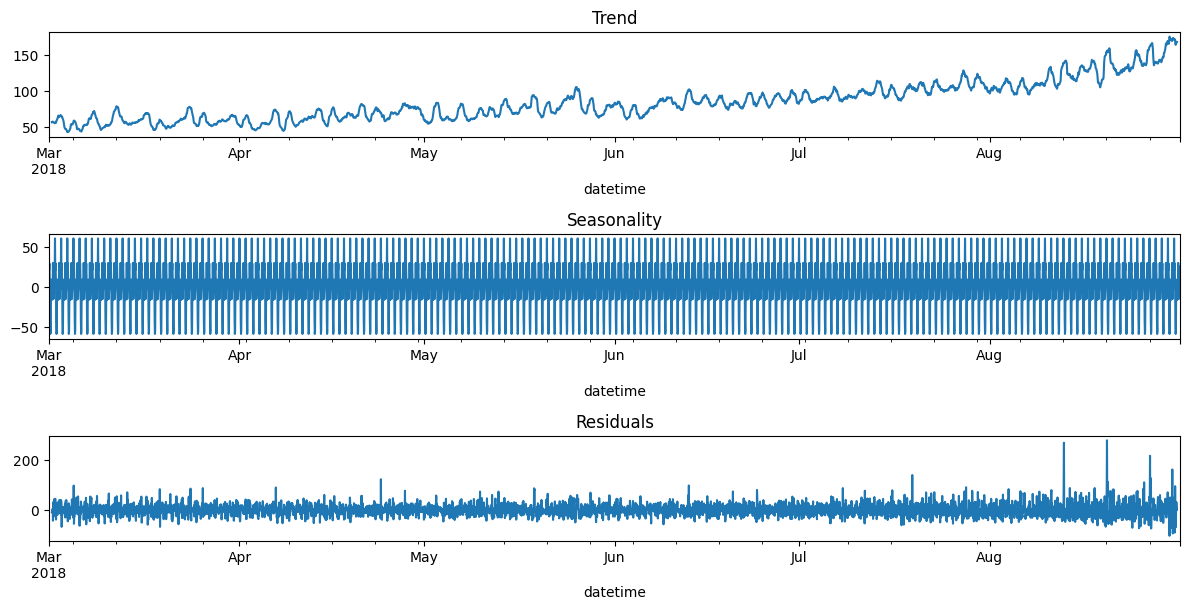

- La tendencia aumenta en marzo, y no tenemos suficientes para definir estacionalidades

In [ ]:
dif_df = df - df.shift()
df['rolling_mean'] = df['num_orders'].rolling(5).mean()
df.plot(figsize=(15, 6))
plt.title('Número de Taxis Pedidos por Hora')
plt.xlabel('Fecha')
plt.ylabel('Número de Taxis')
plt.show()
dif_df.plot(figsize=(15, 6))
plt.title('Número de Taxis Pedidos por Hora diferenciados')
plt.xlabel('Fecha')
plt.ylabel('Número de Taxis')
plt.show()

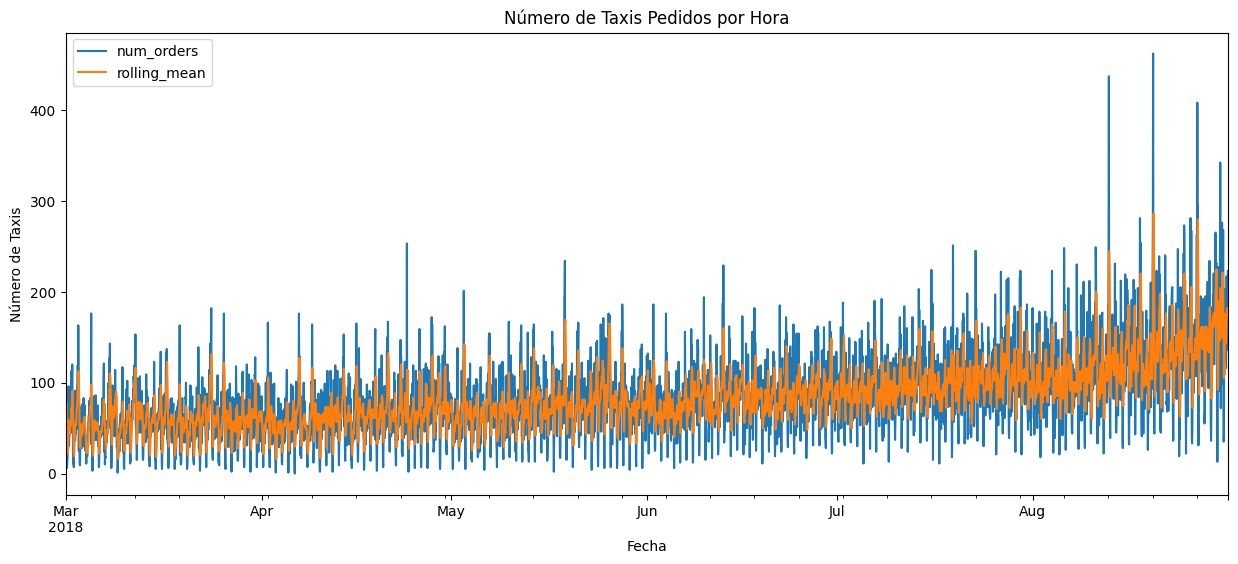

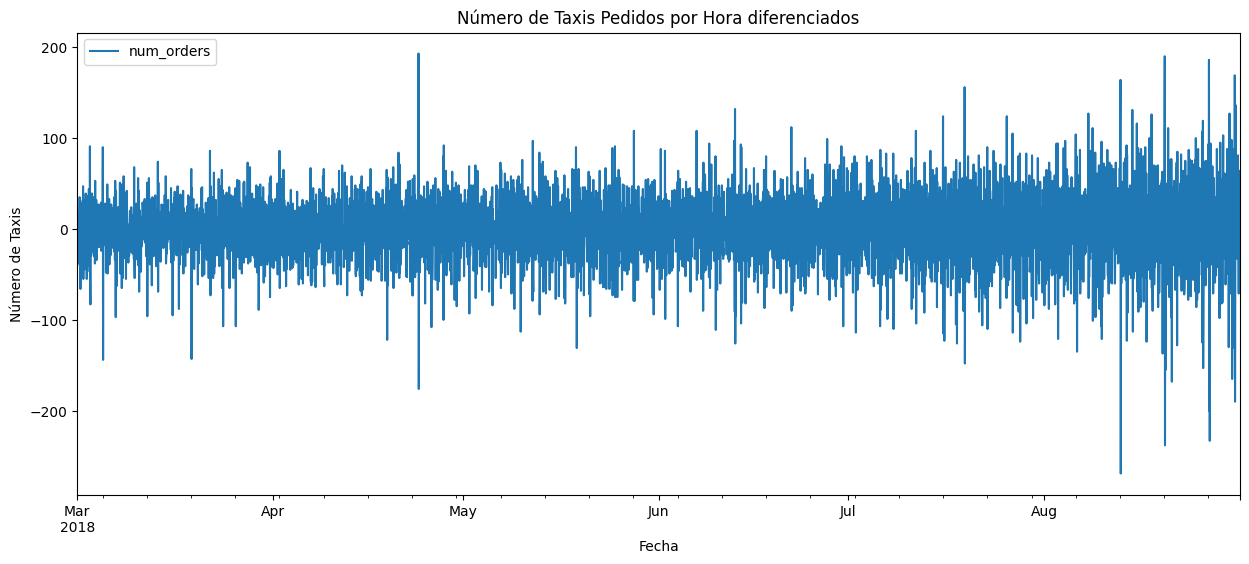

## Formación

In [ ]:
df['hour'] = df.index.hour
for lag in range(1, 4, 1):
    df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    
df = df.fillna(0)
print(df.head())
df.info()

In [ ]:
target = df['num_orders']
features = df.drop('num_orders', axis=1)
train_features, test_features, train_target, test_target = train_test_split(features, target, shuffle=False, test_size=0.1)
train_features, valid_features, train_target, valid_target = train_test_split(train_features, train_target, shuffle=False, test_size=0.1 / 0.9, random_state=12345

In [ ]:
model = LinearRegression()
model.fit(train_features, train_target)
model_pred = model.predict(test_features)
recm_model_score = np.sqrt(mean_squared_error(model_pred, test_target))
print(recm_model_score)

In [ ]:
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='RMSE',
    random_seed=12345,
    use_best_model=True
)

cat_model.fit(
    train_features, 
    train_target, 
    eval_set=(valid_features, valid_target),
    verbose=100
)

cat_pred = cat_model.predict(test_features)
rmse_cat = np.sqrt(mean_squared_error(test_target, cat_pred))
print(f'RMSE CatBoost: {rmse_cat}')

- bestTest = 27.81924106
    bestIteration = 265

    Shrink model to first 266 iterations.
    RMSE CatBoost: 48.005090665906195

In [ ]:
lgb_train = lgb.Dataset(train_features, train_target)
lgb_valid = lgb.Dataset(valid_features, valid_target, reference=lgb_train)

# Parámetros del modelo
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=lgb_valid,
    early_stopping_rounds=10
)

pred_lgb = gbm.predict(test_features, num_iteration=gbm.best_iteration)
rmse_lgb = np.sqrt(mean_squared_error(test_target, pred_lgb))
print(f'RMSE LightGBM: {rmse_lgb}')

- Early stopping, best iteration is:
    [510]	valid_0's rmse: 28.4767
    RMSE LightGBM: 48.85445259145566

best_rmse_rf = float('inf')
best_depth_rf = None

for depth in range(1, 11):
    rf_model = RandomForestRegressor(max_depth=depth, n_estimators=50, random_state=12345)
    rf_model.fit(train_features, train_target)
    rf_model_pred = rf_model.predict(valid_features)
    
    rmse_rf = np.sqrt(mean_squared_error(valid_target, rf_model_pred))
    
    if rmse_rf < best_rmse_rf:
        best_rmse_rf = rmse_rf
        best_depth_rf = depth

final_rf_model = RandomForestRegressor(max_depth=best_depth_rf, n_estimators=100, random_state=12345)
final_rf_model.fit(pd.concat([train_features, valid_features]), pd.concat([train_target, valid_target]))
final_rf_pred = final_rf_model.predict(test_features)
rmse_rf_final = np.sqrt(mean_squared_error(test_target, final_rf_pred))
print(f'Best RMSE RandomForest (depth={best_depth_rf}): {rmse_rf_final}')

- Best RMSE RandomForest (depth=10): 42.33389266870919

## modelo dummy

In [ ]:
median_pred = [train_target.median()] * len(test_target)
rmse_dummy_median = np.sqrt(mean_squared_error(test_target, median_pred))
print(f'RMSE Dummy Median: {rmse_dummy_median}')

## Conclucion general

- Despues de analizar y preparar los datos, probamos hacer las predicciones con cuatro modelos distintos: regresion lineal, catboost, lightgbm y randomforest. Todo esto para evaluar los resultados con la metrica RMSE con el objetivo de que el modelo tenga el menor indice de error posible, luego comparamos todas los resultados de la metrica con el de un modelo dummy que se usa para una pruba de cordura y solo da como prediccion la media de los valores. Despues de todo esto podemos concluir que logramos el objetivo de tener una metrica RMSE en los tres modelos igual o inferior a 48 y al valor del modelo dummy.